# Research Project Code

In [0]:
# import the necessary packages
from collections import deque
import matplotlib as mpl
from imutils.video import VideoStream
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import imutils
import sys
import time
from google.colab.patches import cv2_imshow
PY3 = sys.version_info[0] == 3
if PY3:
    xrange = range


To make the code run properly please upload the POCvid3.mp4 file attached in the .zip to your local environment

## Ball Tracker


In [0]:
#openCV Ball Detector

orangeLower1 = (150 ,20, 90)
orangeUpper1 = (175,160,160)
orangeLower2 = (1,20, 90)
orangeUpper2 = (17,160,160)

# if a video path was not supplied, grab the reference
vs = cv2.VideoCapture('POCvid3.mp4')
# allow the camera or video file to warm up
time.sleep(2.0)

# initialize these lists
mask_list     = []
frame_list    = []
mask_dif_list = []
# First frame
# grab the current frame
frame = vs.read()

# handle the frame from VideoCapture or VideoStream
frame = frame[1]


# set up the ROI for tracking
# setup initial location of window (roi _x,roi_y are coordinates of top left corner)
roi_x,roi_y,w,h = (1406,387,37,37) # simply hardcoded the values

# make list of ball locations (in pixels) and add initial value
ball_loc_2d    = [(roi_x,roi_y)]

roi_cent_y,roi_cent_x = (int(roi_y+0.5*w),int(roi_x+0.5*w))
roi                   = frame[roi_y:roi_y+h,roi_x:roi_x+w,:]

# initial roi (size 145X150)
cv2.rectangle(frame,(int(roi_x-145/2),int(roi_y-150/2)),(int(roi_x+145/2),int(roi_y+150/2)),(255,0,0),3)

hsv_roi               = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
roi_mask1             = cv2.inRange(hsv_roi, orangeLower1,orangeUpper1)
roi_mask2             = cv2.inRange(hsv_roi, orangeLower2,orangeUpper2)
roi_mask              = cv2.bitwise_or(roi_mask1,roi_mask2)

# This is the balls color histogram, the distance from that will be the key in determining the next frame's ROI
roi_hist = cv2.calcHist([hsv_roi],[0],roi_mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# construct a mask for the color "orange" (HSV), then perform
# a series of dilations and erosions to remove any small
# blobs left in the mask
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
mask1 = cv2.inRange(hsv, orangeLower1,orangeUpper1)
mask2 = cv2.inRange(hsv, orangeLower2,orangeUpper2)
mask  = cv2.bitwise_or(mask1,mask2)


# cv2_imshow(cv2.circle(frame.copy(),(roi_cent_x,roi_cent_y),int(h/2),(0,0,255), 1))

# Add to lists (for difference purposes)
frame_list += [frame]
mask_list  += [mask]

# keep looping till end of video
while True:

  if frame is None:
    break
  # grab the current frame
  frame = vs.read()

  # handle the frame from VideoCapture or VideoStream
  frame = frame[1]

#  convert to hsv
  hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)


  # construct a mask for the  ball color, then perform
  # a series of dilations and erosions to remove any small
  # blobs left in the mask
  mask1 = cv2.inRange(hsv, orangeLower1,orangeUpper1)
  mask2 = cv2.inRange(hsv, orangeLower2,orangeUpper2)
  mask  = cv2.bitwise_or(mask1,mask2)

#  add to lists
  frame_list    += [frame]
  mask_list     += [mask]
#   get the difference between frames and masks
  if len(mask_list)>1:
#     We want the pixels that weren't orange that are now orange
    mask_dif       = cv2.bitwise_and(mask_list[-1],cv2.bitwise_not(mask_list[-2]))
    mask_dif       = cv2.erode(mask_dif,None,iterations=2)
    mask_dif       = cv2.dilate(mask_dif,None,iterations=2)
    mask_dif_list += [mask_dif]

#     Define search region edges:
  search_reg_y = (max(roi_cent_y-100,0),min(roi_cent_y+45,int(frame.shape[0]/2)))
  search_reg_x = (max(roi_cent_x-100,0),min(roi_cent_x+50,frame.shape[1]-1))


  roi_edges = np.array([[search_reg_x[0],search_reg_y[0]],[search_reg_x[0],search_reg_y[1]],\
                        [search_reg_x[1],search_reg_y[1]],[search_reg_x[1],search_reg_y[0]]],np.int32)
  cv2.polylines(frame,[roi_edges],True,(255,0,0),3)
#   cv2.polylines(mask_dif,[roi_edges],True,(255,0,0),3)

  # find contours in the mask  that are LEFT OF THE BALL AND UPPER HALF OF SCREEN and initialize the current
#   define search region and then n
  # (x, y) center of the ball
  cnts = cv2.findContours(mask_dif.copy()[search_reg_y[0]:search_reg_y[1],search_reg_x[0]:search_reg_x[1]], cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
#   filter small contours out and add  search regions x,y to get cooridnates of contours in the full picture
  cnts = [c+(search_reg_x[0],search_reg_y[0]) for c in cnts if c.shape[0]>2]
#   print(cnts)
  center = None

  # only proceed if at least one contour was found
  if len(cnts) > 0:
#   get the mean hue of each contour
    cont_mean_hues = np.array([hsv[cont[:,:,1],cont[:,:,0]].mean(0)[0][0] for cont in cnts])
#   get the contour with thehue that is closest to 3 (the basketballs hue in first frame)
    most_orange_idx = ((cont_mean_hues-3)**2).argmin()
    # find the contour whose distance is shortest from roi_cent
    # contour centers (with more than 2 pixels)
    cont_cents = np.array([cont.mean(axis=0) for cont in cnts])

    # update roi center

    roi_cent_x,roi_cent_y = np.array(np.round(cont_cents[most_orange_idx][::-1]),dtype=np.int32)[0]
    c = cnts[most_orange_idx]
    ((x, y), radius) = cv2.minEnclosingCircle(c)
    M = cv2.moments(c)
    center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

    # only proceed if the radius meets a minimum size
    if radius > 0:
      # draw the circle and centroid on the frame,
      # then update the list of tracked points
      cv2.circle(frame, (int(x), int(y)), 15,
        (0, 255, 0), 2)
  # update thelocation list
  ball_loc_2d  +=[center]

  # loop over the set of tracked points
  for i in range(1, len(ball_loc_2d)):
    # if either of the tracked points are None, ignore
    if ball_loc_2d[i - 1] is None or ball_loc_2d[i] is None:
      continue

    # otherwise, compute the thickness of the line and
    # draw the connecting lines
    thickness = int(np.sqrt(10/ float(i + 1)) * 2.5)
    cv2.line(frame, ball_loc_2d[i - 1], ball_loc_2d[i], (0, 0, 255), thickness)  

#   Read next frame


#   key = cv2.waitKey(1) & 0xFF

#   # if the 'q' key is pressed, stop the loop
#   if key == ord("q"):
#     break

# # # if we are not using a video file, stop the camera video stream
# # if not args.get("video", False):
# # 	vs.stop()

# # otherwise, release the camera
# else:
#   vs.release()
# # close all windows
cv2.destroyAllWindows()

## Homography Class

In [0]:
#   seperate function to find intersection between 2 lines
def find_intersect(l1p1,l1p2,l2p1,l2p2,l1vert=False):
  """
  left points should have 0 as y unless l1vert is TRUE
  """
  if l1vert:
    x = l1p1[0]
    m2 = (l2p2[1]-l2p1[1])/(l2p2[0]-l2p1[0])
    n2 = l2p1[1]-m2*l2p1[0]
    y  = m2*x+n2
    return int(x),int(y)
  m1 = (l1p2[1]-l1p1[1])/(l1p2[0]-l1p1[0])
  n1 = l1p1[1]-m1*l1p1[0]
  m2 = (l2p2[1]-l2p1[1])/(l2p2[0]-l2p1[0])
  n2 = l2p1[1]-m2*l2p1[0]
#   fix for errors
  if m1==m2:
    return (-1,-1)
  x  = (n2-n1)/(m1-m2)
  y  = m2*x+n2
  return int(x),int(y)

class BBall_Frame:
  def __init__(self,frame,shot_loc_3d= (676.4,-175.6,0) ):
    self.orig_frame        = frame
    self.shot_loc_3d       = shot_loc_3d
    self.baseline_sideline = None
    self.paint_ft          = None
    self.paint_sideline    = None
    self.sideline_ft       = None
    self.paint_mid         = None
    self.court_mask        = None
    self.frame             = None
  def find_court_points(self,show_plot=False):
    # frame = cv2.imread('court.png')
    # convert color
    frame = cv2.cvtColor(self.orig_frame,cv2.COLOR_BGR2HSV)
    # mask the court colors
    lower = (5,50,140)
    upper = (15,105,250)
    # Ignore the top 30% of the frame (crowd noise)
    mask = cv2.inRange(frame[int(frame.shape[0]*0.3):,:],lower,upper)
    mask = cv2.erode(mask,kernel=None,iterations=0)
    mask = cv2.dilate(mask,kernel=None,iterations=0)
    self.court_mask = mask
    # Find first white pixel in each column (y_coordinate) and make array of x,y point
    first_white_pix= np.array(list(zip(np.arange(mask.shape[1]),mask.argmax(0))))
    


    #differences between consecutive columns
    difs = np.diff(first_white_pix[:,1])

    # Get the slopes for the baseline and sideline 
    (values,counts)           = np.unique(difs,return_counts=True)
    ind                       = np.argsort(counts)[::-1]
    most_common_difs          = np.sort(values[ind][:3])
    baseline_dif,sideline_dif = most_common_difs[0],most_common_difs[-1]

    # plot differences on top of first white pixel plot
    # show plot
    if show_plot:
      plt.scatter(first_white_pix[:,0],first_white_pix[:,1],s=.2)
      plt.plot(difs,color='orange')

    # Find change points (points where the difference between that point and the previous is more than 2 pixels)
    change_points = np.append(np.nonzero(np.abs(difs)> max(np.abs(baseline_dif),np.abs(sideline_dif)))[0],len(first_white_pix))

    # get top 4 streaks start & end indices
    streak_lengths             = np.diff(change_points)
    # take 6 longest streaks
    longest_streaks_start_idxs = change_points[np.sort(np.argsort(streak_lengths)[::-1][:6])]
    longest_streaks_end_idxs   = change_points[np.nonzero(longest_streaks_start_idxs[:, None] == change_points)[1]+1]
    longest_streaks_idxs       = np.vstack((longest_streaks_start_idxs,longest_streaks_end_idxs)).T


    # sort streaks to neg/pos
    signs_list = []
    for streak_idx in longest_streaks_idxs:
      signs_list +=[first_white_pix[streak_idx[1]-1][1]-first_white_pix[streak_idx[0]+1][1]]


     # Only keep baseline1,baseline2, sideline
    signs_list                *= (longest_streaks_end_idxs-longest_streaks_start_idxs)
    desired_streaks_idxs       = np.argsort(signs_list)[[0,1,-1]]
    longest_streaks_start_idxs = longest_streaks_start_idxs[desired_streaks_idxs]
    longest_streaks_end_idxs   = longest_streaks_end_idxs[desired_streaks_idxs]

    # Extract Y coordinate of middle of baseline1 and baseline2 (paint_mid) to be used for second court mask 
    baseline1_end   = first_white_pix[longest_streaks_end_idxs[0]-1]
    baseline2_start = first_white_pix[longest_streaks_start_idxs[1]+1]
    self.paint_mid     = int((0.4*baseline1_end+0.6*baseline2_start)[0]) ,int((0.4*baseline1_end+0.6*baseline2_start)[1])
    
    # First court mask
    copy        = frame.copy()
    lefty_list  = []
    righty_list = []
    for i in range(len(longest_streaks_end_idxs)):
      line   = first_white_pix[longest_streaks_start_idxs[i]+1:longest_streaks_end_idxs[i]]
      [vx,vy,x,y]= cv2.fitLine(line,cv2.DIST_FAIR,0,0.01,0.01)
    # Now find two extreme points (these are just Y values) on the line to draw line and add to compensate for the cropped mask 
      lefty        = int((-x*vy/vx) + y) + int(frame.shape[0]*0.3)
      righty       = int(((mask.shape[1]-x)*vy/vx)+y) + int(frame.shape[0]*0.3)
      lefty_list  += [(0,lefty)]
      righty_list += [(frame.shape[1]-1,righty)]
      
      
#     find intersect point between 2 lines
    self.baseline_sideline = find_intersect(lefty_list[1],righty_list[1], lefty_list[2], righty_list[2])

      #Finally draw the lines
    cv2.line(copy,lefty_list[1],righty_list[1],(255,255,255),2)
    cv2.line(copy,lefty_list[2],righty_list[2],(255,255,255),2)
    cv2.circle(copy, (self.baseline_sideline), 3, (0, 0, 255), 2)
    

    self.frame = copy
    # SECOND MASK
    # Cut the first mask to the mid paint pixel
    mask2            = self.court_mask[self.paint_mid[1]:,self.paint_mid[0]:]
    # Find first white pixel in each column (y_coordinate) and make array of x,y points
    first_white_pix  = np.array(list(zip(np.arange(mask2.shape[1]),mask2.argmax(0))))

    #differences between consecutive columns
    difs             = np.diff(first_white_pix[:,1])

    # Get the slopes for the baseline and sideline 
    (values,counts)           = np.unique(difs,return_counts=True)
    ind                       = np.argsort(counts)[::-1]
    most_common_difs          = np.sort(values[ind][:5])
    ft_dif,paint_dif          = most_common_difs[0],most_common_difs[-1]

    # plot differences on top of first white pixel plot
    # show plot
    if show_plot:
      plt.scatter(first_white_pix[:,0],first_white_pix[:,1],s=.2)
      plt.plot(difs,color='orange')

    # Find change points (points where the difference between that point and the previous is more than 5 pixels)
    change_points = np.append(np.nonzero(np.abs(difs)> max(np.abs(ft_dif),np.abs(paint_dif)))[0],len(first_white_pix))

    # get top 4 streaks start & end indices
    streak_lengths             = np.diff(change_points)
    # take 6 longest streaks (should be enough to get a sufficiently long positive and negative streak)
    longest_streaks_start_idxs = np.asarray(change_points[np.sort(np.argsort(streak_lengths)[::-1][:6])])
    longest_streaks_end_idxs   = np.asarray(change_points[np.nonzero(longest_streaks_start_idxs[:, None] == change_points)[1]+1])
    longest_streaks_end_idxs   = longest_streaks_end_idxs-0.6*(longest_streaks_end_idxs-longest_streaks_start_idxs)
    longest_streaks_end_idxs   = longest_streaks_end_idxs.astype(int)
    longest_streaks_idxs       = np.vstack((longest_streaks_start_idxs,longest_streaks_end_idxs)).T
    
    # sort streaks to neg/pos
    signs_list = []
    for streak_idx in longest_streaks_idxs:
      signs_list +=[first_white_pix[streak_idx[1]-1][1]-first_white_pix[streak_idx[0]+1][1]]


    # Only keep longest positive and longest negative (paint and FT line)
    signs_list                *= (longest_streaks_end_idxs-longest_streaks_start_idxs)
    desired_streaks_idxs       = np.argsort(signs_list)[[-1,0]]
    longest_streaks_start_idxs = longest_streaks_start_idxs[desired_streaks_idxs]
    longest_streaks_end_idxs   = longest_streaks_end_idxs[desired_streaks_idxs]

    # Draw lines
    copy = self.frame.copy()
    for i in range(len(longest_streaks_end_idxs)):
      line   = first_white_pix[longest_streaks_start_idxs[i]+1:longest_streaks_end_idxs[i]]+(self.paint_mid[0],self.paint_mid[1])
      [vx,vy,x,y]= cv2.fitLine(line,cv2.DIST_FAIR,0,0.001,0.001)
      
    # Now find two extreme points on the line to draw line
      lefty = int((-x*vy/vx) + y) +int(frame.shape[0]*0.3)
      righty = int(((copy.shape[1]-x)*vy/vx)+y) + int(frame.shape[0]*0.3)
      
      lefty_list  += [(0,lefty)]
      righty_list += [(frame.shape[1]-1,righty)]
    
    self.paint_ft       = find_intersect(lefty_list[3],righty_list[3], lefty_list[4], righty_list[4])
    self.paint_sideline = find_intersect(lefty_list[3],righty_list[3], lefty_list[1], righty_list[1])
    self.sideline_ft    = find_intersect(lefty_list[2],righty_list[2], lefty_list[4], righty_list[4])
    


    cv2.line(copy,lefty_list[3],righty_list[3],(255,255,255),2)
    cv2.line(copy,lefty_list[4],righty_list[4],(255,255,255),2)
    cv2.circle(copy, (self.paint_ft), 3, (0, 0, 255), 2)
    cv2.circle(copy, (self.paint_sideline), 3, (0, 0, 255), 2)
    cv2.circle(copy, (self.sideline_ft), 3, (0, 0, 255), 2)
    
    self.frame = copy
    
  def find_backboard_points(self,show_plot=False):
#     frame = cv2.cvtColor(self.orig_frame,cv2.COLOR_BGR2HSV)
    frame = self.frame
    lower1 = (120,10,50)
    upper1 = (165,80,130)

    mask = cv2.inRange(frame,lower1,upper1)
    mask = cv2.erode(mask,kernel=None,iterations=3)
    mask = cv2.dilate(mask,kernel=None,iterations=3)
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    center = None

    # find the largest contour in the mask, then use
    # it to compute the minimum enclosing circle and
    # centroid
    c = max(cnts, key=cv2.contourArea)
    ((x, y), radius) = cv2.minEnclosingCircle(c)
    M = cv2.moments(c)
    center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

  # only proceed if the radius meets a minimum size
    # draw the circle and centroid on the frame,
    # then update the list of tracked points
    x,y,w,h = cv2.boundingRect(c)
  # Centerize x and increase window size
    x       = int(x-0.15*w)
    w,h     = int(w*1.3), int(h*1)

    backboard_mask = mask[y:y+h,x:x+w]

    
  
  #  First we get the top of the backboard
    top_white_pix  = np.array(list(zip(np.arange(backboard_mask.shape[1]),backboard_mask.argmax(0))))
    difs = np.diff(top_white_pix[:,1])
    # Get the slopes for the baseline and sideline 
    (values,counts)           = np.unique(difs,return_counts=True)
    ind                       = np.argsort(counts)[::-1]
    most_common_difs          = np.sort(values[ind][:2])
    change_points             = np.append(np.nonzero(np.abs(difs)> max(np.abs(most_common_difs)))[0],len(top_white_pix))
    # get top 4 streaks start & end indices
    streak_lengths             = np.diff(change_points)
    # take longest streak
    longest_streaks_start_idxs = change_points[np.sort(np.argsort(streak_lengths)[::-1][:1])]
    longest_streaks_end_idxs   = change_points[np.nonzero(longest_streaks_start_idxs[:, None] == change_points)[1]+1]
    longest_streaks_idxs       = np.vstack((longest_streaks_start_idxs,longest_streaks_end_idxs)).T

    copy                       = frame.copy()
    line                       = top_white_pix[longest_streaks_start_idxs[0]:longest_streaks_end_idxs[0]]+(x,y)
    
    [vx,vy,x0,y0]= cv2.fitLine(line,cv2.DIST_FAIR,0,0.001,0.001)

  # Now find two extreme points on the line to draw line and add to compensate for cropped mask
    lefty = int((-x0*vy/vx) + y0)
    righty = int(((copy.shape[1]-x0)*vy/vx)+y0)

    #Finally draw the line
    cv2.line(copy,(frame.shape[1],righty),(0,lefty),(255,255,255),2)
  # Find left backboard value
    leftiest_white_pix        = np.array(list(zip(np.arange(backboard_mask.shape[0]),backboard_mask.argmax(1))))
    (_,counts2)               = np.unique(leftiest_white_pix,return_counts=True)
    left_backboard_value      = np.argmax(counts2)
  #   add x value to compensate for mask
    left_backboard_value     += x                                                 

  # Find Right backboard value
    temp = backboard_mask*(np.arange(backboard_mask.shape[1]))
    rightest_white_pix  = np.array(list(zip(np.arange(backboard_mask.shape[0]),temp.argmax(1))))

    # Get the slopes for the baseline and sideline 
    (_,counts3)               = np.unique(rightest_white_pix,return_counts=True)
    right_backboard_value     = np.argmax(counts3)
  #   add x value to compensate for mask
    right_backboard_value    += x
    cv2.line(frame,(right_backboard_value,frame.shape[1]),(right_backboard_value,0),(255,0,0),1)

  # Now that we have all thew lines, we extract the points
    self.top_left_backboard       =find_intersect((left_backboard_value,0),(left_backboard_value,copy.shape[1]),(0,lefty),(copy.shape[1],righty),True)
    self.top_right_backboard      =find_intersect((right_backboard_value,0),(right_backboard_value,copy.shape[1]),(0,lefty),(copy.shape[1],righty),True)
    cv2.circle(copy, (self.top_left_backboard), 3, (0, 0, 255), 2)
    cv2.circle(copy, (self.top_right_backboard), 3, (0, 0, 255), 2)
    if show_plot:
      plt.scatter(top_white_pix[:,0],top_white_pix[:,1],s=.2)
      plt.plot(difs,color='orange')    

    self.frame = copy    

# Find homography mapping in all frames
# Run operations on all frames to find the points needed for homography
bball_frames=[]
for i,frame in enumerate(frame_list[:-1]):
  bball_frame= BBall_Frame(frame)
  bball_frame.find_court_points()
  bball_frame.find_backboard_points()
  bball_frames+=[bball_frame]



    

In [0]:
# Find homography mapping in all frames
# Create video file
out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (1920,1080))
# Run operations on all frames to find the points needed for homography
bball_frames=[]
for i,frame in enumerate(frame_list[:-1]):
  bball_frame= BBall_Frame(frame)
  bball_frame.find_court_points()
  bball_frame.find_backboard_points()
  bball_frames+=[bball_frame]
  out.write(bball_frame.frame)
  
out.release()


In [0]:
# Make empty list for ball's 3D location
ball_3d_location = []
# Fixed things 
size         = frame_list[0].shape
focal_length = size[1]
center       = (size[1]/2, size[0]/2)
camera_matrix= np.array(
                         [[focal_length, 0, center[0]],
                         [0, focal_length, center[1]],
                         [0, 0, 1]], dtype = "double"
                         )
dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion



# Function for projecting the image plane on the court plane
def courtProject(im_point):
    z        = 0.0
    camMat   = np.asarray(camera_matrix)
    invCam   = np.linalg.inv(camMat)
    invRot   = np.linalg.inv(rotMat)

    uvPoint = np.ones(shape=(3, 1))
    # Image point
    uvPoint[0,0] = im_point[0]
    uvPoint[1,0] = im_point[1]
    
    temp         = np.matmul(invRot.dot(invCam), uvPoint)
    temp2        = invRot.dot(translation_vector)


    s = (z+temp2[2,0])/ temp[2, 0]
    #Court Model Point
    cmPoint = invRot.dot((np.matmul(s*invCam, uvPoint) - translation_vector))
    cmPoint[2] = z

    return cmPoint
  
# After using pin-pointing the point on the court where the shot was released and converting it using the courtProject function this is what we got
shot_loc_3d= (676.4,-175.6,0)
# The tracked points coordinates in the "Real World"
model_points = np.array([
(-159.96,1524/2,0),         #Baseline-sideline
(-159.96,-244,0),           #Paint-sideline
(419.04,-244,0),            #Paint-FT
(419.04,1524/2,0)]          #Sideline-FT
    ,dtype=np.float32
)
for i,frame in enumerate(bball_frames):
  f             =frame
  #This array has the pixel coordinates of the court & backboard points
  image_points  =np.array([f.baseline_sideline,
  f.paint_sideline,
  f.paint_ft,
  f.sideline_ft]
                          ,dtype=np.float32)

  (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs)

  rotMat, _ = cv2.Rodrigues(rotation_vector)
  
  if i in [9,17]:
    (left_backboard_2d, jacobian)  = cv2.projectPoints(np.array([(-37.96, -182.9/2, 0.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)
    (right_backboard_2d, jacobian) = cv2.projectPoints(np.array([(-37.96, 182.9/2, 0.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)
    (mid_basket_2d, jacobian)      = cv2.projectPoints(np.array([(0.0,0.0,0.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)
    (shot_loc_2d, jacobian)        = cv2.projectPoints(np.array([shot_loc_3d]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)
    shot_loc_u,shot_loc_v          = shot_loc_2d[0][0][0],shot_loc_2d[0][0][1]
    shot_plane_bb_proj_int         = find_intersect(l1p1=(mid_basket_2d[0][0][0],mid_basket_2d[0][0][1]),l1p2=(shot_loc_u,shot_loc_v),
                      l2p1=(left_backboard_2d[0][0][0],left_backboard_2d[0][0][1]),
                 l2p2=(right_backboard_2d[0][0][0],right_backboard_2d[0][0][1]))
    # finding the point on backboard (NOT THE PROJ) where the intersect happens
    
    backboard_intercept            = find_intersect(l1p1=(shot_plane_bb_proj_int[0],0),l1p2=shot_plane_bb_proj_int,
                   l2p1=f.top_left_backboard,l2p2=f.top_right_backboard,l1vert=True)
    # The difference in pixels from the shot plane and the backboard
    dif1                           = shot_plane_bb_proj_int[1]-backboard_intercept[1]
    # The intercept between the ball and the shot-plane
    ball_shotplane_int             = find_intersect(l1p1= ball_loc_2d[i],l1p2= (ball_loc_2d[i][0],0),
               l2p1=(mid_basket_2d[0][0][0],mid_basket_2d[0][0][1]),l2p2=(shot_loc_u,shot_loc_v),l1vert=True)
    # get the x,y of the ball in flight
    ball_x,ball_y                  = courtProject(ball_shotplane_int)[:,0][:-1]

    #height of ball (in pixels)
    dif2                           = ball_shotplane_int[1]- ball_loc_2d[i][1]

    # Real ball height (396.32 is the height of the backboard)
    ball_z                         = (dif2/dif1)*396.32

    ball_3d_location              += [np.array([ball_x,ball_y,ball_z])]

ball_3d_location = np.array(ball_3d_location)

# Add middle of basket position to reflect made shot
ball_3d_location                  = np.append(ball_3d_location,[[0,0,304.8]],axis=0)
# Reduce x,y to distance from basket
dist_from_basket                  = (np.sqrt(ball_3d_location[:,0]**2+ball_3d_location[:,1]**2)*np.sign(ball_3d_location[:,0])).reshape(-1,1)
ball_3d_location                  = np.concatenate((ball_3d_location,dist_from_basket),axis=1)

# Fitting the trajectory of the shot
x,y,z,d = ball_3d_location.T
fitdz   = np.polyfit(d, z, 2)
fitarc  = np.poly1d(fitdz)

shot_dist    = np.sqrt((np.array(shot_loc_3d)**2).sum())
dist_ar      = np.linspace(0,shot_dist,len(frame_list))[::-1]
mpl.style.use('seaborn')
plt.figure(figsize=(15,15))

plt.scatter(dist_ar,fitarc(dist_ar),s=470,alpha=0.7,edgecolors='black',color='darkorange')
plt.scatter(d,z,s=470)
# Adding basket and backboard to plot
plt.plot([-37.96,-37.96+15.1], [304.8, 304.8], 'k-', color = 'orangered',linewidth=2)
plt.plot([-37.96+15.1,-37.96+15.1+45.72], [304.8, 304.8], 'k-', color = 'orangered',linewidth=4)
plt.plot([-37.96,-37.96], [396.32-121.9, 396.32], 'k-', color = 'black',linewidth=8,alpha=0.7)
plt.xlabel('Distance From Mid-Basket Point (cm)',fontsize=20)
plt.ylabel('Height (cm)',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(0,520)
# Times by 30 to adjust for the frame rate then divide by 100 to adjust for meters instead of cm

# Find Shot Parameters
v0_x,v0_y = (dist_ar[1]-dist_ar[0])*30/100,(fitarc(dist_ar[1])-fitarc(dist_ar[0]))*30/100
v0        = np.sqrt(v0_x**2+v0_y**2)
theta     = np.rad2deg(np.arctan(v0_y/v0_x))

## Trajectory fitting

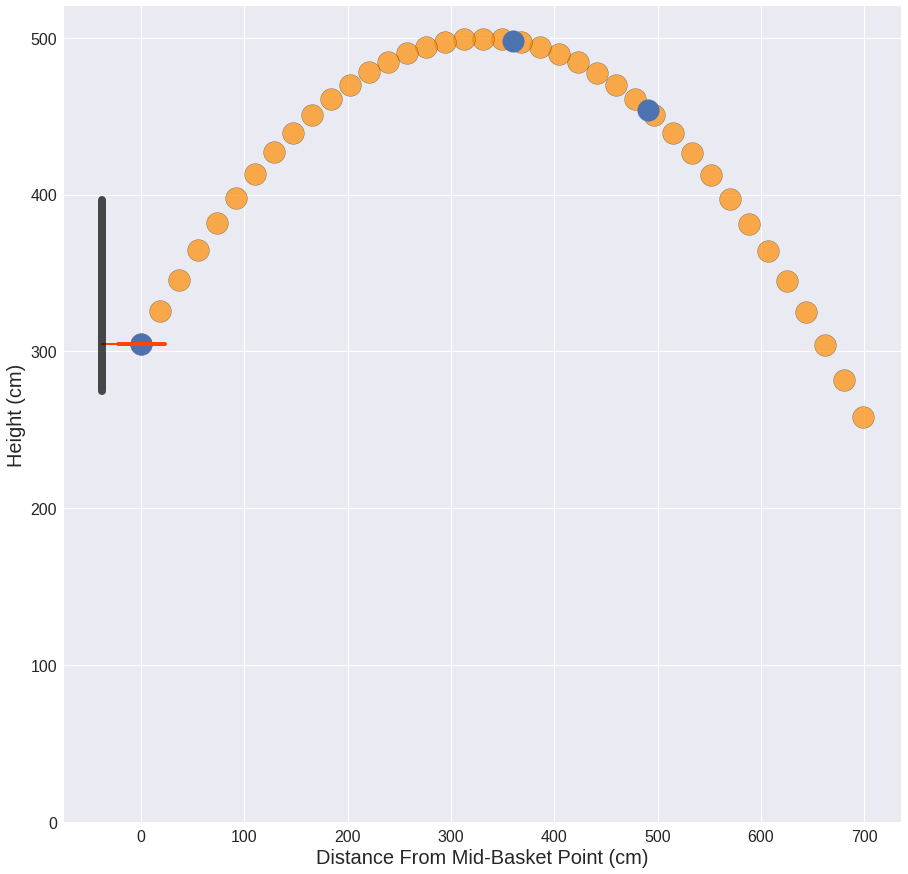

In [20]:

# Fitting the trajectory of the shot
x,y,z,d = ball_3d_location.T
fitdz   = np.polyfit(d, z, 2)
fitarc  = np.poly1d(fitdz)

shot_dist    = np.sqrt((np.array(shot_loc_3d)**2).sum())
dist_ar      = np.linspace(0,shot_dist,len(frame_list))[::-1]
mpl.style.use('seaborn')
plt.figure(figsize=(15,15))

plt.scatter(dist_ar,fitarc(dist_ar),s=470,alpha=0.7,edgecolors='black',color='darkorange')
plt.scatter(d,z,s=470)
# Adding basket and backboard to plot
plt.plot([-37.96,-37.96+15.1], [304.8, 304.8], 'k-', color = 'orangered',linewidth=2)
plt.plot([-37.96+15.1,-37.96+15.1+45.72], [304.8, 304.8], 'k-', color = 'orangered',linewidth=4)
plt.plot([-37.96,-37.96], [396.32-121.9, 396.32], 'k-', color = 'black',linewidth=8,alpha=0.7)
plt.xlabel('Distance From Mid-Basket Point (cm)',fontsize=20)
plt.ylabel('Height (cm)',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(0,520)
# Times by 30 to adjust for the frame rate then divide by 100 to adjust for meters instead of cm
v0_x,v0_y = (dist_ar[1]-dist_ar[0])*30/100,(fitarc(dist_ar[1])-fitarc(dist_ar[0]))*30/100
v0        = np.sqrt(v0_x**2+v0_y**2)
theta     = np.rad2deg(np.arctan(v0_y/v0_x))

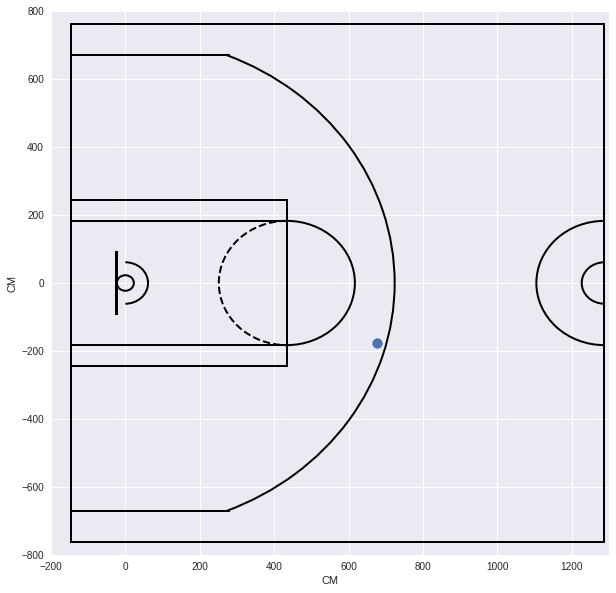

In [9]:
from matplotlib.patches import Circle, Rectangle, Arc
mpl.style.use('seaborn')

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=22.86, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-22.86,-182.88/2 ),-1,183, linewidth=lw, color=color,)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle(( -22.86-122,-487.88/2),  579,487.88, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-22.86-122,-365.75/2 ), 579,365.75,  linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc(( 434.14,0),365.75,365.75,  theta1=90, theta2=270,
                         linewidth=lw, color=color, fill=False,linestyle='dashed')
    # Create free throw bottom arc
    bottom_free_throw = Arc((434.14,0 ),365.75,365.75, theta1=270, theta2=90,
                            linewidth=lw, color=color)
    
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 122, 122, theta1=270, theta2=90, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle(( -22.86-121.9,-670.56),426,0, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((-22.86-121.9,670.56), 426,0, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes§
    three_arc = Arc((0, 0), 723.96*2, 723.96*2, theta1=292, theta2=68, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((1432.56-22.86-122,0), 365.7,365.7, theta1=90, theta2=270,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((1432.56-22.86-122,0), 121.9,121.9, theta1=90, theta2=270,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc,center_outer_arc,center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-22.86-122,-762),1432,762*2, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax
plt.figure(figsize=(10,10))
draw_court(outer_lines=True)
plt.scatter(shot_loc_3d[0],shot_loc_3d[1],label='Shooting Location',s=100)

plt.ylim(-800,800)
plt.xlim(-200,1300)
plt.xlabel('CM')
plt.ylabel('CM')

plt.show()